In [1]:
#!/usr/bin/env python3

%reload_ext autoreload
%autoreload 2

# System
import os
import sys

# Maths
import numpy as np

# PCovR utilities
from regression import LR, KRR, SparseKRR, PCovR, KPCovR, SparseKPCovR
from decomposition import PCA, KPCA, SparseKPCA
from kernels import build_kernel, center_kernel, center_kernel_fast
from selection import FPS, CUR
from split import simple_split
from tools import sorted_eigh

# ASE
from ase.io import read, write

# SOAP
from rascal.representations import SphericalInvariants as SOAP

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Make the plots look nicer
plot_parameters = {
    'lines.linewidth': 1.0,
    'lines.markersize': 2,
    'patch.linewidth': 1.0,
    'hatch.linewidth': 1.0,
    'axes.linewidth': 1.0,
    'xtick.top': True,
    'xtick.bottom': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'xtick.major.size': 4.0,
    'xtick.minor.size': 2.0,
    'xtick.major.pad': 5.0,
    'xtick.minor.pad': 5.0,
    'ytick.left': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
    'ytick.major.size': 4.0,
    'ytick.minor.size': 2.0,
    'ytick.major.pad': 5.0,
    'ytick.minor.pad': 5.0   
}

for pp in plot_parameters.keys():
    mpl.rcParams[pp] = plot_parameters[pp]

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# Read xyz files
s = read('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/datasets/CSD-1000R.xyz', index=':50')

# Extract chemical shifts
cs = []
for ss in s:
    ss.wrap()
    cs.append(ss.arrays['CS_local'])

In [3]:
# Compute SOAPs (from librascal tutorial)
soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=6,
           max_angular=6,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5)

In [4]:
soap_rep = soap.transform(s)

In [5]:
X = soap_rep.get_features(soap)
Y = np.concatenate(cs)

In [6]:
# Split SOAPs into structures
n_atoms = [ss.get_number_of_atoms() for ss in s]
structure_idxs = np.cumsum(n_atoms)

X_split = np.split(X, structure_idxs[0:-1]) # Last one is empty by construction of np.split
Y_split = np.split(Y, structure_idxs[0:-1])

In [7]:
# Train-Test split by structures
f_train = 0.80
n_total = len(X_split)
n_train = int(np.floor(f_train*n_total))

idxs = np.arange(0, n_total)
np.random.shuffle(idxs)
idxs_train = idxs[0:n_train]
idxs_test = idxs[n_train:]

X_train = [X_split[i] for i in idxs_train]
Y_train = [Y_split[i] for i in idxs_train]
structure_idxs_train = np.cumsum([n_atoms[i] for i in idxs_train])

X_test = [X_split[i] for i in idxs_test]
Y_test = [Y_split[i] for i in idxs_test]
structure_idxs_test = np.cumsum([n_atoms[i] for i in idxs_test])

print(n_atoms)
print(idxs_train, idxs_test)
print(structure_idxs_train)
print(structure_idxs_test)
print([x.shape for x in X_train])
print([x.shape for x in X_test])

X_train = np.concatenate(X_train, axis=0)
Y_train = np.concatenate(Y_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
Y_test = np.concatenate(Y_test, axis=0)

[180, 84, 176, 176, 104, 108, 134, 152, 148, 100, 128, 86, 80, 132, 88, 104, 196, 188, 98, 76, 108, 112, 148, 104, 176, 132, 62, 172, 160, 52, 144, 86, 144, 144, 172, 176, 76, 86, 132, 76, 144, 106, 68, 132, 88, 160, 82, 150, 160, 136]
[ 0  3 41 35 25 36 26 48 20 33 45 24  6 40 22 10 19 37 29 15 16  2 38 13
 47 21 27 31 44 11 17  5  1  7 18  9 12 32 34  4] [30 23 49 14 46 28 42 43  8 39]
[ 180  356  462  638  770  846  908 1068 1176 1320 1480 1656 1790 1934
 2082 2210 2286 2372 2424 2528 2724 2900 3032 3164 3314 3426 3598 3684
 3772 3858 4046 4154 4238 4390 4488 4588 4668 4812 4984 5088]
[ 144  248  384  472  554  714  782  914 1062 1138]
[(180, 2520), (176, 2520), (106, 2520), (176, 2520), (132, 2520), (76, 2520), (62, 2520), (160, 2520), (108, 2520), (144, 2520), (160, 2520), (176, 2520), (134, 2520), (144, 2520), (148, 2520), (128, 2520), (76, 2520), (86, 2520), (52, 2520), (104, 2520), (196, 2520), (176, 2520), (132, 2520), (132, 2520), (150, 2520), (112, 2520), (172, 2520), (86, 2

In [8]:
# Center the data
X_mean = np.mean(X_train, axis=0)
Y_mean = np.mean(Y_train)

X_train -= X_mean
X_test -= X_mean
Y_train -= Y_mean
Y_test -= Y_mean

# FPS

In [9]:
# Select FPS components from train set
n_FPS = 20
idxs, d = FPS(X_train.T, n_FPS)

X_train = X_train[:, idxs]
X_test = X_test[:, idxs]

In [10]:
# Select FPS environments from train set
n_env_FPS = 100
env_idxs, env_d = FPS(X_train, n_env_FPS)

In [11]:
X_train_split = np.split(X_train, structure_idxs_train)[0:-1]
Y_train_split = np.split(Y_train, structure_idxs_train)[0:-1]

X_test_split = np.split(X_test, structure_idxs_test)[0:-1]
Y_test_split = np.split(Y_test, structure_idxs_test)[0:-1]

In [12]:
K_train = build_kernel(X_train_split, X_train_split, kernel='gaussian')
K_test = build_kernel(X_test_split, X_train_split, kernel='gaussian')

In [13]:
K_train_nystrom = build_kernel(X_train_split, X_train_split, XR=X_train[env_idxs, :], kernel='gaussian')
K_test_nystrom = build_kernel(X_test_split, X_train_split, XR=X_train[env_idxs, :], kernel='gaussian')
#K_train_nystrom = build_kernel(X_train_split, X_train_split, XR=X_train_split[0:3], kernel='gaussian')
#K_test_nystrom = build_kernel(X_test_split, X_train_split, XR=X_train_split[0:3], kernel='gaussian')

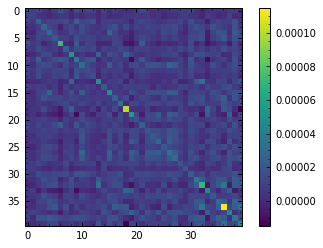

In [14]:
plt.imshow(K_train-K_train_nystrom)
plt.colorbar()
plt.show()

In [15]:
print(np.linalg.norm(K_train - K_train_nystrom))

0.0005066684890553833


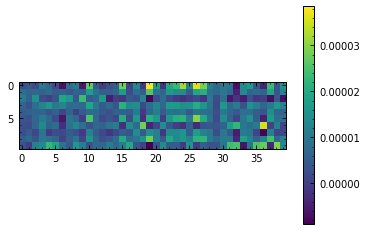

In [16]:
plt.imshow(K_test-K_test_nystrom)
plt.colorbar()
plt.show()

In [17]:
print(np.linalg.norm(K_test-K_test_nystrom))

0.00023023814202560296


# Unconventional kernel centering

In [18]:
K_train_center = center_kernel(K_train)
K_test_center = center_kernel(K_test, K_ref=K_train)

In [19]:
K_test_test = build_kernel(X_test_split, X_test_split, kernel='gaussian')

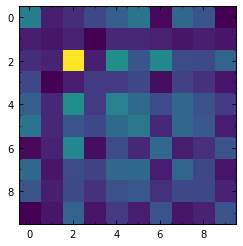

In [20]:
plt.imshow(K_test_test)
plt.show()

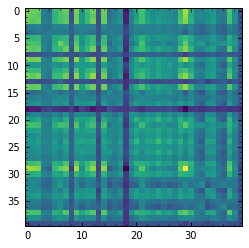

In [21]:
plt.imshow(K_train)
plt.show()

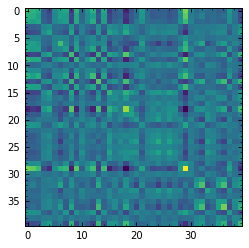

In [22]:
plt.imshow(K_train_center)
plt.show()

In [23]:
one_MN = np.ones((K_test_test.shape[0], K_train.shape[0])) / K_train.shape[0]
one_NM = np.ones((K_train.shape[0], K_test_test.shape[0])) / K_train.shape[0]
K_test_test_center = K_test_test - np.matmul(K_test, one_NM) - np.matmul(one_MN, K_test.T) + np.matmul(np.matmul(one_MN, K_train), one_NM)

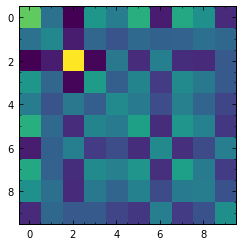

In [24]:
plt.imshow(K_test_test_center)
plt.show()

In [25]:
K_test_test_center_fast = K_test_test - np.mean(K_test.T, axis=0) - np.mean(K_test, axis=1).reshape(-1, 1) + np.mean(K_train)

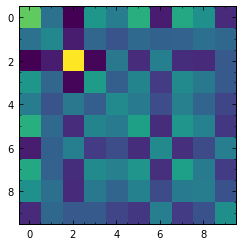

In [26]:
plt.imshow(K_test_test_center_fast)
plt.show()

In [27]:
print(np.mean(K_train_center), np.mean(K_test_center))
print(np.mean(K_train_center, axis=0), np.mean(K_test_center, axis=0))
print(np.mean(K_train_center, axis=1), np.mean(K_test_center, axis=1))

1.519617764955683e-17 -3.0531133177191805e-18
[-2.77555756e-17  5.82867088e-17  1.94289029e-17  9.43689571e-17
 -9.43689571e-17  2.77555756e-18  2.49800181e-17 -9.43689571e-17
 -5.55111512e-17  6.38378239e-17  6.10622664e-17  7.77156117e-17
 -4.71844785e-17  2.85882429e-16 -1.36002321e-16  1.47104551e-16
  2.49800181e-17 -1.16573418e-16  2.27595720e-16  6.66133815e-17
  2.22044605e-17  2.69229083e-16  8.60422844e-17 -8.60422844e-17
 -1.94289029e-17  8.32667268e-18  6.66133815e-17 -7.77156117e-17
  1.55431223e-16 -1.44328993e-16  1.72084569e-16  5.55111512e-17
 -3.33066907e-17 -1.60982339e-16 -2.63677968e-16  8.60422844e-17
 -7.49400542e-17 -3.60822483e-17  1.97064587e-16 -1.97064587e-16] [-3.39052801e-03 -3.37393895e-03 -2.34447794e-03  6.69385438e-04
  1.51633984e-03 -9.12786752e-04 -6.72594107e-03 -9.34457388e-04
 -2.55976733e-05 -2.81825068e-03  3.15712540e-03 -6.54146141e-04
 -9.89159933e-04 -3.62820935e-03 -1.81047672e-03  4.69219674e-03
 -2.22170567e-04  2.65262696e-03  1.2306167

In [28]:
print(np.mean(K_test_test_center))
print(np.mean(K_test_test_center, axis=0))
print(np.mean(K_test_test_center, axis=1))

0.001936693715706267
[ 0.00745965  0.00081295 -0.00386512  0.00353615  0.00316411  0.00559586
 -0.00344841  0.00548664  0.00315076 -0.00252566]
[ 0.00745965  0.00081295 -0.00386512  0.00353615  0.00316411  0.00559586
 -0.00344841  0.00548664  0.00315076 -0.00252566]


In [29]:
phi = np.linalg.cholesky(K_test_test_center)

In [30]:
np.mean(phi, axis=0)

array([ 3.96304315e-02, -2.79828254e-03,  6.05600121e-03,  6.64818700e-03,
        1.19924810e-02,  1.54452946e-03,  9.47076675e-03,  5.13430614e-05,
        4.51865837e-03,  4.59316713e-03])

In [31]:
phi = np.linalg.cholesky(K_train_center+np.eye(K_train_center.shape[0])*1.0E-14)

In [32]:
np.mean(phi, axis=0)

array([ 1.18724475e-15,  2.12321480e-15,  1.56068734e-15,  1.16254228e-14,
       -2.49466246e-15,  9.67455283e-15, -1.27151761e-14,  5.70975559e-15,
        1.04097286e-14,  2.99723354e-15,  1.90875094e-14,  1.35988226e-14,
       -2.46113893e-15,  2.71247434e-14, -8.39813245e-15,  4.24331143e-14,
        1.48635661e-14,  1.37322554e-14,  1.94719241e-14,  6.43467918e-14,
        2.90608032e-14, -4.03041316e-16,  3.01885253e-14, -2.54336482e-15,
        1.65877945e-14,  2.12960292e-14, -1.68181983e-14, -2.36191275e-14,
        4.19551546e-14,  1.49350963e-14,  5.51745932e-14,  8.57271936e-14,
        1.28103496e-13,  6.18010417e-14,  8.83711507e-16,  1.20577111e-13,
        4.31901867e-13,  4.01589374e-13,  3.59026697e-13,  1.62408178e-08])

In [33]:
kpca1 = KPCA(n_kpca=2)
kpca1.fit(center_kernel(K_test_test))
T1 = kpca1.transform(center_kernel(K_test_test))

kpca2 = KPCA(n_kpca=2)
#kpca2.fit(K_test_test_center)
kpca2.fit(center_kernel(K_test_test))
T2 = kpca2.transform(K_test_test_center)

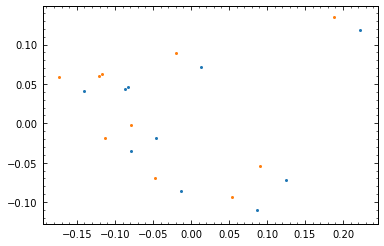

In [34]:
plt.scatter(T1[:, 0], T1[:, 1])
plt.scatter(T2[:, 0], T2[:, 1])
plt.show()

# Sparse Kernel Centering

In [35]:
K_train_sparse = build_kernel(X_train_split, X_train[env_idxs, :], kernel='gaussian')
K_test_sparse = build_kernel(X_test_split, X_train[env_idxs, :], kernel='gaussian')
K_ref_sparse = build_kernel(X_train[env_idxs, :], X_train[env_idxs, :], kernel='gaussian')

In [36]:
Phi_center = np.mean(K_train_sparse, axis=0)
K_train_sparse -= Phi_center
K_test_sparse -= Phi_center

K_ref_sparse = center_kernel(K_ref_sparse)

K_approx = np.matmul(np.matmul(K_train_sparse, np.linalg.pinv(K_ref_sparse, rcond=1.0E-12)), K_train_sparse.T)
Phi_scale = np.sqrt(np.trace(K_approx) / K_train_sparse.shape[0])
K_train_sparse /= Phi_scale
K_test_sparse /= Phi_scale

In [37]:
U, V = sorted_eigh(K_ref_sparse, tiny=1.0E-12)
Phi_train = np.matmul(np.matmul(K_train_sparse, V), np.diagflat(1.0/np.sqrt(U)))
Phi_test = np.matmul(np.matmul(K_test_sparse, V), np.diagflat(1.0/np.sqrt(U)))

In [38]:
K_train_phi = np.matmul(Phi_train, Phi_train.T)
K_test_phi = np.matmul(Phi_test, Phi_train.T)

In [39]:
print(np.trace(K_train_phi)/K_train_phi.shape[0])
print(np.linalg.norm(Phi_train)**2/Phi_train.shape[0])
print(np.linalg.norm(Phi_test)**2/Phi_test.shape[0])

1.0000000000000777
1.0000000000000777
0.9837918846816963


In [40]:
print(np.mean(K_train_phi, axis=0))
print(np.mean(K_train_phi, axis=1))
print(np.mean(K_test_phi, axis=1))
print(np.mean(Phi_train, axis=0))
print(np.mean(Phi_test, axis=0))

[-7.43849426e-16  1.35447209e-15  4.10782519e-16  4.99600361e-17
  6.96664948e-16 -1.43635104e-15  3.30664315e-15  9.10382880e-16
 -7.38298311e-16 -2.22044605e-17 -7.58941521e-16 -1.15463195e-15
  6.99440506e-16 -9.27036226e-16  6.66133815e-16  2.32314168e-15
  9.04831765e-16 -8.44680229e-16 -1.80966353e-15  1.59872116e-15
 -5.30131494e-16  9.06219544e-16 -1.39610545e-15 -1.77635684e-16
  8.64586180e-16 -2.24716079e-15 -9.99417563e-16  1.17961196e-16
 -6.16173779e-16  2.22044605e-16 -1.07275300e-15  9.82547377e-16
  7.46624984e-16 -2.77833312e-15  1.34510458e-15  8.04911693e-17
  1.64313008e-15 -2.47024623e-16 -1.22124533e-15  4.05231404e-16]
[-7.54951657e-16  1.31006317e-15  4.32986980e-16  5.55111512e-17
  6.88338275e-16 -1.43773882e-15  3.26405569e-15  8.82627305e-16
 -7.54951657e-16 -1.11022302e-17 -7.60502772e-16 -1.16573418e-15
  6.99440506e-16 -8.93729535e-16  6.32827124e-16  2.30926389e-15
  9.02056208e-16 -8.43769499e-16 -1.77635684e-15  1.60982339e-15
 -5.32907052e-16  8.9928

# Kernel building with centered/uncentered raw data

In [41]:
X_train_raw = [X_split[i] for i in idxs_train]
X_test_raw = [X_split[i] for i in idxs_test]

In [42]:
X_mean = np.mean(np.concatenate(X_train_raw, axis=0), axis=0) # Evironment-based centering

## Structure-based

In [43]:
# Uncentered raw data
K_train_raw_linear = build_kernel(X_train_raw, X_train_raw, kernel='linear')
K_test_raw_linear = build_kernel(X_test_raw, X_train_raw, kernel='linear')

K_train_raw_gaussian = build_kernel(X_train_raw, X_train_raw, kernel='gaussian')
K_test_raw_gaussian = build_kernel(X_test_raw, X_train_raw, kernel='gaussian')

In [44]:
K_test_raw_linear = center_kernel(K_test_raw_linear, K_ref=K_train_raw_linear)
K_train_raw_linear = center_kernel(K_train_raw_linear)

K_test_raw_gaussian = center_kernel(K_test_raw_gaussian, K_ref=K_train_raw_gaussian)
K_train_raw_gaussian = center_kernel(K_train_raw_gaussian)

In [45]:
print('K_train_raw_linear')
print(K_train_raw_linear)
print('K_test_raw_linear')
print(K_test_raw_linear)

print('K_train_raw_gaussian')
print(K_train_raw_gaussian)
print('K_test_raw_gaussian')
print(K_test_raw_gaussian)

K_train_raw_linear
[[ 0.06362707  0.04768972  0.04162962 ...  0.02495458 -0.00042026
  -0.04172468]
 [ 0.04768972  0.0454791   0.02887373 ...  0.01995845 -0.00447738
  -0.02980667]
 [ 0.04162962  0.02887373  0.04374398 ...  0.0167276   0.00027779
  -0.03284576]
 ...
 [ 0.02495458  0.01995845  0.0167276  ...  0.03988717 -0.01925102
  -0.03791445]
 [-0.00042026 -0.00447738  0.00027779 ... -0.01925102  0.02844367
   0.00805362]
 [-0.04172468 -0.02980667 -0.03284576 ... -0.03791445  0.00805362
   0.06800653]]
K_test_raw_linear
[[-3.79697364e-02 -3.36776262e-02 -2.60904420e-02  1.10206266e-02
   1.36496200e-02 -2.31939537e-02 -8.62047438e-02 -3.48762764e-03
   7.21515807e-03 -3.47474217e-02  3.81511467e-02 -8.35128194e-03
  -1.59665116e-02 -3.18494019e-02 -1.53310856e-02  6.08478538e-02
  -7.08288820e-03  3.00021831e-02  2.15321609e-02  5.10140569e-02
   4.90829450e-02 -4.79887962e-02  2.61392291e-02  3.61592714e-02
   7.32993536e-02  1.81517742e-02  6.75543373e-02  2.69742223e-02
   1.6818

In [46]:
# Centered raw data (by env)
K_train_ctr_linear = build_kernel([(x-X_mean) for x in X_train_raw], 
                                  [(x-X_mean) for x in X_train_raw], 
                                  kernel='linear')
K_test_ctr_linear = build_kernel([(x-X_mean) for x in X_test_raw], 
                                 [(x-X_mean) for x in X_train_raw], 
                                 kernel='linear')

K_train_ctr_gaussian = build_kernel([(x-X_mean) for x in X_train_raw], 
                                    [(x-X_mean) for x in X_train_raw], 
                                    kernel='gaussian')
K_test_ctr_gaussian = build_kernel([(x-X_mean) for x in X_test_raw], 
                                   [(x-X_mean) for x in X_train_raw], 
                                   kernel='gaussian')

In [47]:
K_test_ctr_linear = center_kernel(K_test_raw_linear, K_ref=K_train_raw_linear)
K_train_ctr_linear = center_kernel(K_train_raw_linear)

K_test_ctr_gaussian = center_kernel(K_test_raw_gaussian, K_ref=K_train_raw_gaussian)
K_train_ctr_gaussian = center_kernel(K_train_raw_gaussian)

In [48]:
print('K_train_ctr_linear')
print(K_train_ctr_linear)
print('K_test_ctr_linear')
print(K_test_ctr_linear)

print('K_train_ctr_gaussian')
print(K_train_ctr_gaussian)
print('K_test_ctr_gaussian')
print(K_test_ctr_gaussian)

K_train_ctr_linear
[[ 0.06362707  0.04768972  0.04162962 ...  0.02495458 -0.00042026
  -0.04172468]
 [ 0.04768972  0.0454791   0.02887373 ...  0.01995845 -0.00447738
  -0.02980667]
 [ 0.04162962  0.02887373  0.04374398 ...  0.0167276   0.00027779
  -0.03284576]
 ...
 [ 0.02495458  0.01995845  0.0167276  ...  0.03988717 -0.01925102
  -0.03791445]
 [-0.00042026 -0.00447738  0.00027779 ... -0.01925102  0.02844367
   0.00805362]
 [-0.04172468 -0.02980667 -0.03284576 ... -0.03791445  0.00805362
   0.06800653]]
K_test_ctr_linear
[[-3.79697364e-02 -3.36776262e-02 -2.60904420e-02  1.10206266e-02
   1.36496200e-02 -2.31939537e-02 -8.62047438e-02 -3.48762764e-03
   7.21515807e-03 -3.47474217e-02  3.81511467e-02 -8.35128194e-03
  -1.59665116e-02 -3.18494019e-02 -1.53310856e-02  6.08478538e-02
  -7.08288820e-03  3.00021831e-02  2.15321609e-02  5.10140569e-02
   4.90829450e-02 -4.79887962e-02  2.61392291e-02  3.61592714e-02
   7.32993536e-02  1.81517742e-02  6.75543373e-02  2.69742223e-02
   1.6818

## Environment-based

In [49]:
X_train_raw = np.concatenate(X_train_raw, axis=0)
X_test_raw = np.concatenate(X_test_raw, axis=0)

In [50]:
# Uncentered raw data
K_train_raw_linear = build_kernel(X_train_raw, X_train_raw, kernel='linear')
K_test_raw_linear = build_kernel(X_test_raw, X_train_raw, kernel='linear')

K_train_raw_gaussian = build_kernel(X_train_raw, X_train_raw, kernel='gaussian')
K_test_raw_gaussian = build_kernel(X_test_raw, X_train_raw, kernel='gaussian')

In [51]:
K_test_raw_linear = center_kernel(K_test_raw_linear, K_ref=K_train_raw_linear)
K_train_raw_linear = center_kernel(K_train_raw_linear)

K_test_raw_gaussian = center_kernel(K_test_raw_gaussian, K_ref=K_train_raw_gaussian)
K_train_raw_gaussian = center_kernel(K_train_raw_gaussian)

In [52]:
print('K_train_raw_linear')
print(K_train_raw_linear)
print('K_test_raw_linear')
print(K_test_raw_linear)

print('K_train_raw_gaussian')
print(K_train_raw_gaussian)
print('K_test_raw_gaussian')
print(K_test_raw_gaussian)

K_train_raw_linear
[[ 0.43960877  0.44687827  0.44126723 ... -0.22272365 -0.22217453
  -0.22908633]
 [ 0.44687827  0.45801909  0.44987408 ... -0.22571824 -0.22495742
  -0.23210978]
 [ 0.44126723  0.44987408  0.44414772 ... -0.22236983 -0.22178887
  -0.2286133 ]
 ...
 [-0.22272365 -0.22571824 -0.22236983 ...  0.4367545   0.43898595
   0.4385714 ]
 [-0.22217453 -0.22495742 -0.22178887 ...  0.43898595  0.44499522
   0.44518751]
 [-0.22908633 -0.23210978 -0.2286133  ...  0.4385714   0.44518751
   0.45049806]]
K_test_raw_linear
[[-0.085948   -0.07872728 -0.08462018 ... -0.02793627 -0.01674602
  -0.00461353]
 [-0.08906185 -0.08222911 -0.08813642 ... -0.02933848 -0.01866632
  -0.00745757]
 [-0.08881525 -0.08161125 -0.08757495 ... -0.03272553 -0.0221871
  -0.01078052]
 ...
 [-0.05805837 -0.0530802  -0.05774385 ... -0.1035867  -0.09128647
  -0.07945903]
 [ 0.02780096  0.03293833  0.02660669 ... -0.07969754 -0.07106354
  -0.06143557]
 [ 0.03134041  0.03688218  0.0302183  ... -0.079789   -0.07164

In [53]:
# Centered raw data
X_mean = np.mean(X_train_raw, axis=0)
K_train_ctr_linear = build_kernel(X_train_raw-X_mean, X_train_raw-X_mean, kernel='linear')
K_test_ctr_linear = build_kernel(X_test_raw-X_mean, X_train_raw-X_mean, kernel='linear')

K_train_ctr_gaussian = build_kernel(X_train_raw-X_mean, X_train_raw-X_mean, kernel='gaussian')
K_test_ctr_gaussian = build_kernel(X_test_raw-X_mean, X_train_raw-X_mean, kernel='gaussian')

In [54]:
print('K_train_raw_linear')
print(K_train_raw_linear)
print('K_test_raw_linear')
print(K_test_raw_linear)

K_train_raw_linear
[[ 0.43960877  0.44687827  0.44126723 ... -0.22272365 -0.22217453
  -0.22908633]
 [ 0.44687827  0.45801909  0.44987408 ... -0.22571824 -0.22495742
  -0.23210978]
 [ 0.44126723  0.44987408  0.44414772 ... -0.22236983 -0.22178887
  -0.2286133 ]
 ...
 [-0.22272365 -0.22571824 -0.22236983 ...  0.4367545   0.43898595
   0.4385714 ]
 [-0.22217453 -0.22495742 -0.22178887 ...  0.43898595  0.44499522
   0.44518751]
 [-0.22908633 -0.23210978 -0.2286133  ...  0.4385714   0.44518751
   0.45049806]]
K_test_raw_linear
[[-0.085948   -0.07872728 -0.08462018 ... -0.02793627 -0.01674602
  -0.00461353]
 [-0.08906185 -0.08222911 -0.08813642 ... -0.02933848 -0.01866632
  -0.00745757]
 [-0.08881525 -0.08161125 -0.08757495 ... -0.03272553 -0.0221871
  -0.01078052]
 ...
 [-0.05805837 -0.0530802  -0.05774385 ... -0.1035867  -0.09128647
  -0.07945903]
 [ 0.02780096  0.03293833  0.02660669 ... -0.07969754 -0.07106354
  -0.06143557]
 [ 0.03134041  0.03688218  0.0302183  ... -0.079789   -0.07164

In [55]:
K_test_ctr_linear = center_kernel(K_test_raw_linear, K_ref=K_train_raw_linear)
K_train_ctr_linear = center_kernel(K_train_raw_linear)

K_test_ctr_gaussian = center_kernel(K_test_raw_gaussian, K_ref=K_train_raw_gaussian)
K_train_ctr_gaussian = center_kernel(K_train_raw_gaussian)

In [56]:
print('K_train_ctr_linear')
print(K_train_ctr_linear)
print('K_test_ctr_linear')
print(K_test_ctr_linear)

print('K_train_ctr_gaussian')
print(K_train_ctr_gaussian)
print('K_test_ctr_gaussian')
print(K_test_ctr_gaussian)

K_train_ctr_linear
[[ 0.43960877  0.44687827  0.44126723 ... -0.22272365 -0.22217453
  -0.22908633]
 [ 0.44687827  0.45801909  0.44987408 ... -0.22571824 -0.22495742
  -0.23210978]
 [ 0.44126723  0.44987408  0.44414772 ... -0.22236983 -0.22178887
  -0.2286133 ]
 ...
 [-0.22272365 -0.22571824 -0.22236983 ...  0.4367545   0.43898595
   0.4385714 ]
 [-0.22217453 -0.22495742 -0.22178887 ...  0.43898595  0.44499522
   0.44518751]
 [-0.22908633 -0.23210978 -0.2286133  ...  0.4385714   0.44518751
   0.45049806]]
K_test_ctr_linear
[[-0.085948   -0.07872728 -0.08462018 ... -0.02793627 -0.01674602
  -0.00461353]
 [-0.08906185 -0.08222911 -0.08813642 ... -0.02933848 -0.01866632
  -0.00745757]
 [-0.08881525 -0.08161125 -0.08757495 ... -0.03272553 -0.0221871
  -0.01078052]
 ...
 [-0.05805837 -0.0530802  -0.05774385 ... -0.1035867  -0.09128647
  -0.07945903]
 [ 0.02780096  0.03293833  0.02660669 ... -0.07969754 -0.07106354
  -0.06143557]
 [ 0.03134041  0.03688218  0.0302183  ... -0.079789   -0.07164

# Centering structure kernels for linear models

## Structure X

In [70]:
X_train_raw = np.stack([np.mean(X_split[i], axis=0) for i in idxs_train], axis=0)
X_test_raw = np.stack([np.mean(X_split[i], axis=0) for i in idxs_test], axis=0)

In [71]:
X_mean_str = np.mean(X_train_raw, axis=0) # Structure-based centering

In [72]:
# Centered raw data (by env, uses X_mean from above)
K_train_ctr_linear = build_kernel(X_train_raw-X_mean, X_train_raw-X_mean, kernel='linear')
K_test_ctr_linear = build_kernel(X_test_raw-X_mean, X_train_raw-X_mean, kernel='linear')

In [73]:
print(np.mean(K_train_ctr_linear))
print(np.mean(K_train_ctr_linear, axis=0))
print(np.mean(K_train_ctr_linear, axis=1))

0.0003799747301746431
[-1.65138244e-03 -6.86550919e-04 -1.69014290e-03  1.57289156e-03
  1.73696520e-03  2.05434129e-04  3.42918096e-03 -2.05692948e-03
  4.37739893e-03 -1.74920476e-03 -1.15016029e-03 -1.11175355e-03
 -2.64762451e-03  5.73805530e-03 -1.73898196e-03 -5.58721581e-05
  2.15149063e-03 -5.41685721e-04  4.85079039e-03  2.98315302e-04
 -2.81072226e-03  1.22605005e-03 -9.74319379e-04 -8.43732199e-04
 -2.96649639e-03 -7.10907210e-05 -1.87963478e-03  5.33587994e-04
 -2.44121164e-03 -2.30488046e-03 -1.43241430e-03  3.19452180e-03
  5.50637878e-03 -1.37559064e-03 -7.74585454e-04  3.22958670e-03
  6.75122850e-03 -2.74094912e-03  1.57160288e-03  4.52142614e-03]
[-1.65138244e-03 -6.86550919e-04 -1.69014290e-03  1.57289156e-03
  1.73696520e-03  2.05434129e-04  3.42918096e-03 -2.05692948e-03
  4.37739893e-03 -1.74920476e-03 -1.15016029e-03 -1.11175355e-03
 -2.64762451e-03  5.73805530e-03 -1.73898196e-03 -5.58721581e-05
  2.15149063e-03 -5.41685721e-04  4.85079039e-03  2.98315302e-04
 -

In [74]:
print(np.mean(K_test_ctr_linear))
print(np.mean(K_test_ctr_linear, axis=0))
print(np.mean(K_test_ctr_linear, axis=1))

-0.0004032269654488617
[-0.00887356 -0.00717405 -0.00644748  0.00152232  0.00386758 -0.00335062
 -0.01549951 -0.00297753  0.00122899 -0.00753418  0.00626996 -0.00261528
 -0.00438559 -0.00568222 -0.00507274  0.01101773 -0.00058748  0.00448208
  0.0043095   0.00798513  0.00792308 -0.00898172  0.0051286   0.00678824
  0.01204255  0.00471001  0.01172076  0.00424615  0.00119107 -0.01188539
  0.00200825 -0.00394607 -0.01158815  0.0090315   0.00450985 -0.0047786
 -0.01111739  0.00188928 -0.00368769 -0.00181648]
[-2.38758553e-03  1.52047646e-03 -2.02096480e-03  5.35213856e-05
 -2.22147071e-03 -2.43591699e-03  2.98510604e-03 -2.02138852e-03
 -9.58983496e-05  2.59185136e-03]


In [75]:
# Centered raw data (by str)
K_train_ctr_linear = build_kernel(X_train_raw-X_mean_str, X_train_raw-X_mean_str, kernel='linear')
K_test_ctr_linear = build_kernel(X_test_raw-X_mean_str, X_train_raw-X_mean_str, kernel='linear')

In [76]:
print(np.mean(K_train_ctr_linear))
print(np.mean(K_train_ctr_linear, axis=0))
print(np.mean(K_train_ctr_linear, axis=1))

4.2500725161431773e-19
[-5.55111512e-18 -2.16840434e-18 -6.59194921e-18  4.42354486e-18
  5.29090660e-18 -2.51534904e-18 -9.54097912e-19 -4.33680869e-18
  1.07552856e-17 -6.07153217e-18 -2.01661604e-18 -6.41847686e-18
 -4.68375339e-18  1.43982049e-17 -9.36750677e-18  3.98986399e-18
  4.94396191e-18  1.76860479e-18  1.16226473e-17  4.11996826e-18
 -4.94396191e-18 -1.95156391e-18 -2.21177243e-18 -1.44198889e-18
 -4.07660017e-18  1.37761439e-18  6.50521303e-20  2.42861287e-18
 -5.89805982e-18 -1.02348685e-17 -3.03576608e-18  3.72965547e-18
  3.81639165e-18  3.85975973e-18 -2.60208521e-19  5.55111512e-18
  1.11022302e-17 -5.03069808e-18  2.77555756e-18  1.04083409e-17]
[-4.85722573e-18 -2.77555756e-18 -8.32667268e-18  3.98986399e-18
  4.68375339e-18 -2.42861287e-18  6.93889390e-19 -4.33680869e-18
  1.21430643e-17 -6.93889390e-18 -2.08166817e-18 -6.59194921e-18
 -4.85722573e-18  1.31838984e-17 -9.71445147e-18  5.55111512e-18
  5.29090660e-18  1.73472348e-18  9.71445147e-18  4.51028104e-18
 

In [77]:
print(np.mean(K_test_ctr_linear))
print(np.mean(K_test_ctr_linear, axis=0))
print(np.mean(K_test_ctr_linear, axis=1))

1.3877787807814457e-19
[-0.00643897 -0.0057043  -0.00397414  0.00073263  0.00291381 -0.00277285
 -0.01814549 -0.0001374  -0.0023652  -0.00500178  0.00820333 -0.00072032
 -0.00095476 -0.01063707 -0.00255055  0.0118568  -0.00195577  0.00580697
  0.00024191  0.00847002  0.01151701 -0.00942457  0.00688612  0.00841517
  0.01579225  0.0055643   0.0143836   0.00449577  0.00441548 -0.0087973
  0.00422386 -0.00635739 -0.01631133  0.01119029  0.00606763 -0.00722499
 -0.01708541  0.00541343 -0.00447609 -0.0055547 ]
[ 6.93889390e-19  1.12757026e-18 -4.85722573e-18  6.24500451e-18
 -3.03576608e-18 -6.93889390e-19 -1.04083409e-18 -1.04083409e-18
  1.38777878e-18  0.00000000e+00]


## Environment X

In [78]:
X_train_raw = [X_split[i] for i in idxs_train]
X_test_raw = [X_split[i] for i in idxs_test]

In [79]:
# Centered raw data (by str)
K_train_ctr_linear = build_kernel([(x-X_mean_str) for x in X_train_raw], 
                                  [(x-X_mean_str) for x in X_train_raw], 
                                  kernel='linear')
K_test_ctr_linear = build_kernel([(x-X_mean_str) for x in X_test_raw], 
                                 [(x-X_mean_str) for x in X_train_raw], 
                                 kernel='linear')

In [80]:
print(np.mean(K_train_ctr_linear))
print(np.mean(K_train_ctr_linear, axis=0))
print(np.mean(K_train_ctr_linear, axis=1))

-3.5561831257524543e-19
[-6.93889390e-18 -6.33174069e-18 -9.36750677e-18  3.90312782e-18
  4.51028104e-18 -4.51028104e-18  1.43114687e-18 -8.50014503e-18
  1.24900090e-17 -1.00613962e-17 -2.66713734e-18 -7.11236625e-18
 -1.07552856e-17  1.31838984e-17 -9.54097912e-18  3.38271078e-18
  4.77048956e-18 -1.35660797e-18  1.82145965e-17  3.16587034e-18
 -5.63785130e-18 -1.75640752e-18 -2.73218947e-18 -3.85975973e-18
 -4.16333634e-18 -2.53262851e-19 -1.30104261e-18  1.82145965e-18
 -7.97972799e-18 -1.24900090e-17 -4.85722573e-18  5.46437895e-18
  5.89805982e-18  4.51028104e-18 -1.45283091e-18  4.59701721e-18
  1.00613962e-17 -7.28583860e-18  1.73472348e-18  9.71445147e-18]
[-6.93889390e-18 -5.20417043e-18 -7.97972799e-18  3.64291930e-18
  4.85722573e-18 -5.55111512e-18  1.38777878e-18 -8.15320034e-18
  1.28369537e-17 -1.00613962e-17 -3.46944695e-18 -7.11236625e-18
 -9.02056208e-18  1.28369537e-17 -8.32667268e-18  4.16333634e-18
  5.55111512e-18 -1.38777878e-18  1.59594560e-17  5.20417043e-18


In [81]:
print(np.mean(K_test_ctr_linear))
print(np.mean(K_test_ctr_linear, axis=0))
print(np.mean(K_test_ctr_linear, axis=1))

-6.591949208711867e-19
[-0.00643897 -0.0057043  -0.00397414  0.00073263  0.00291381 -0.00277285
 -0.01814549 -0.0001374  -0.0023652  -0.00500178  0.00820333 -0.00072032
 -0.00095476 -0.01063707 -0.00255055  0.0118568  -0.00195577  0.00580697
  0.00024191  0.00847002  0.01151701 -0.00942457  0.00688612  0.00841517
  0.01579225  0.0055643   0.0143836   0.00449577  0.00441548 -0.0087973
  0.00422386 -0.00635739 -0.01631133  0.01119029  0.00606763 -0.00722499
 -0.01708541  0.00541343 -0.00447609 -0.0055547 ]
[ 0.00000000e+00  3.12250226e-18 -1.11022302e-17  1.73472348e-18
 -4.07660017e-18 -1.73472348e-18  2.08166817e-18 -6.93889390e-19
  1.38777878e-18  6.93889390e-19]
